<a href="https://colab.research.google.com/github/RGivisiez/Olist-delivery-delay/blob/main/E_Commerce_Delivery_Delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sobre o dataset

A Olist é uma empresa de marketplace brasileira que agrega vendedores e divulga seus produtos. Diversas análilses de seu dataset já foram feitas e podem ser encontradas nesta página do [Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce). Seu dataset contêm mais de 100.000 ordens de vendas feitas por mais de 1.000 vendedores.

# Objetivo

Como foi visto nos resultados do [notebook](https://github.com/RGivisiez/Olist-sellers-K-Means), onde classificamos os vendedores como bons, medianos e ruins, uma baixa avaliação dos vendedores está correlacionada com o atraso da entrega. O **objetivo é prever possíveis atrasos na entrega** e avisar o consumir previamente. Desta forma esperamos que o consumidor fique mais satisfeito, já que foi avisado da possibilidade de atraso, diminuindo assim o número de reclamações, aumentando o possibilidade de uma avaliação melhor do vendedor e aumentando as chances de comprar novamente no site. 

### Python Import

In [1]:
!pip install geopy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

import geopy.distance

In [3]:
%cd Dataset/o-list

/project/Dataset/o-list


### Funções auxiliares



In [4]:
def return_scores(classifier, X, y, name, scoring=["recall", "accuracy"]):

  '''
     classifier: classificador
     X:          dataset
     y:          variável alvo
     name:       nome do classificador
     scoring:    escores que serão calculados

     return:     array com os escores
  '''

  scores = cross_validate(classifier, X, y,
                        scoring = scoring, cv=5, n_jobs=-1)
  
  results = []

  for key in scores.keys():

    if key.split('_')[1] in scoring:
      
      mean = np.mean(scores[key])
      results.append(mean)

      std = np.std(scores[key])
      results.append(std)

      print('<{0}>: {1} {0}_err: {2}'.format(key.split('_')[1], 
                                             np.round(mean, 3),
                                             np.round(std, 3)))

  results.append(name)

  return results

In [5]:
def distance(x):
  coord1 = (x['customer_lat'], x['customer_lng'])
  coord2 = (x['seller_lat'], x['seller_lng'])

  return geopy.distance.geodesic(coord1, coord2).km

In [6]:
def plot_silhouette_scores(models, data):

  silhouette_scores = []
  ks = []

  for model in models:
    model.fit(data)
    silhouette_scores.append(silhouette_score(data, model.labels_))
    ks.append(model.n_clusters)

  plt.figure(figsize=(8, 3))
  plt.plot(ks, silhouette_scores, "bo-")
  plt.xlabel("n_cluster", fontsize=14)
  plt.ylabel("Silhouette score", fontsize=14)

  plt.show()

#Abrindo os dados

A separação entre os datasets disponibilizados é dada por:


![a](https://i.imgur.com/HRhd2Y0.png)

### Abrindo os datasets


In [7]:
products = pd.read_csv('olist_products_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

items = pd.read_csv("olist_order_items_dataset.csv")
items.rename(columns={'order_item_id':'order_item_qty'}, inplace=True)

orders = pd.read_csv("olist_orders_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
geoloc = pd.read_csv("olist_geolocation_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
#payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

### Trocando os nomes dos produtos para inglês



In [8]:
products = pd.merge(products, category_translation, how="left", 
                    on="product_category_name")

products.drop('product_category_name', axis=1, inplace=True)
products.rename(columns={'product_name_lenght':'product_name_length',
                         'product_description_lenght':'product_description_length',
                         'product_category_name_english':'product_category_name'},
                inplace=True)

del category_translation

### Removendo outliers das geolocalizações

In [9]:
# Removing some outliers
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geoloc = geoloc[geoloc.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geoloc = geoloc[geoloc.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geoloc = geoloc[geoloc.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geoloc = geoloc[geoloc.geolocation_lng <=  -34.79314722]

### Unificando todos os dados e limpando os dados

In [10]:
df = pd.merge(orders, reviews, on='order_id', how='left')
df = pd.merge(df, items, on='order_id', how='left')
df = pd.merge(df, customers, on='customer_id', how='left')
df = pd.merge(df, products, on='product_id', how='left')
df = pd.merge(df, sellers, on='seller_id', how='left')

#### Obtendo os dados geográficos dos cosumidores e dos vendedores

In [11]:
df = pd.merge(df, geoloc.groupby('geolocation_zip_code_prefix').mean().reset_index(),
                    how='left',
                    left_on='customer_zip_code_prefix',
                    right_on='geolocation_zip_code_prefix').rename(columns={
                                                                            'geolocation_lat':'customer_lat',
                                                                            'geolocation_lng':'customer_lng'}).drop('geolocation_zip_code_prefix', axis=1)

In [12]:
df = pd.merge(df, geoloc.groupby('geolocation_zip_code_prefix').mean().reset_index(),
                    how='left',
                    left_on='seller_zip_code_prefix',
                    right_on='geolocation_zip_code_prefix').rename(columns={
                                                                            'geolocation_lat':'seller_lat',
                                                                            'geolocation_lng':'seller_lng'}).drop('geolocation_zip_code_prefix', axis=1)

#### Deletando os pedidos que não foram entregues

In [13]:
df = df[df.order_status == 'delivered'].drop('order_status', axis=1)

#### Selecionando as colunas que serão usadas para criar novas features e descartando os NaNs.

In [14]:
columns = ['order_id', 'customer_id', 'product_id',
           'seller_id', 'customer_unique_id',
            
          'order_approved_at', 'shipping_limit_date',
          'order_delivered_customer_date', 'order_estimated_delivery_date',
          'order_delivered_carrier_date', 'order_purchase_timestamp',
          
          'order_item_qty', 'freight_value', 
          'product_weight_g', 'product_length_cm',
          'product_height_cm', 'product_width_cm', 'product_category_name',
            
          'customer_zip_code_prefix', 'customer_city', 'customer_state',
          'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_lat',
          'customer_lng', 'seller_lat', 'seller_lng',
          
          'review_id', 'review_score',
          ]

In [15]:
df = df[columns].dropna()

# Novas features

In [16]:
#Distância entre o vendedor e o consumidor
df['customer_seller_dist'] = df.apply(lambda x: distance(x), axis=1)

In [17]:
#Criando a variável alvo
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df['is_delayed'] = df['delivery_delay'].apply(lambda x: 0 if x < 0 else 1)

In [18]:
#Densidade e volume do produto
df['product_volume'] = df['product_width_cm'] * df['product_length_cm'] * df['product_height_cm']
df['product_density'] = df['product_weight_g'] / df['product_volume']

In [19]:
#Dia e mês que o pedido foi feito
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

df["purchase_day"] = df["order_purchase_timestamp"].apply(lambda x: x.day_name())
df["purchase_month"] = df["order_purchase_timestamp"].apply(lambda x: x.month)

In [20]:
#Transformando os dias da semana em categorias
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc = enc.fit(df['purchase_day'])
df['purchase_day'] = enc.transform(df['purchase_day'])

In [21]:
#Considerando somente os pedidos de um único estado
df = df[(df.customer_state == 'RJ')]
df.shape

(13783, 37)

In [22]:
#Dividindo o CEP dos vendedores e dos usuários
df['customer_zip1'] = df['customer_zip_code_prefix'].astype(str).str[0:1].astype(int)
df['customer_zip2'] = df['customer_zip_code_prefix'].astype(str).str[0:2].astype(int)
df['customer_zip3'] = df['customer_zip_code_prefix'].astype(str).str[0:3].astype(int)
df['customer_zip4'] = df['customer_zip_code_prefix'].astype(str).str[0:4].astype(int)

df['seller_zip1'] = df['seller_zip_code_prefix'].astype(str).str[0:1].astype(int)
df['seller_zip2'] = df['seller_zip_code_prefix'].astype(str).str[0:2].astype(int)
df['seller_zip3'] = df['seller_zip_code_prefix'].astype(str).str[0:3].astype(int)
df['seller_zip4'] = df['seller_zip_code_prefix'].astype(str).str[0:4].astype(int)

In [23]:
#Variável binária indicando se o vender está no mesmo estado que o comprador.
df['same_state'] = (df['customer_zip1'] - df['seller_zip1']).clip(0, 1)

In [24]:
#População por zip
df['customer_zip2_pop'] = df.groupby(['customer_zip2']).agg({'customer_zip2':'count'})
df['customer_zip3_pop'] = df.groupby(['customer_zip3']).agg({'customer_zip3':'count'})
df['customer_zip4_pop'] = df.groupby(['customer_zip4']).agg({'customer_zip4':'count'})

In [25]:
for idx in range(2, 5):
  name = 'customer_zip' + str(idx)
  df[name + '_pop'] = df[[name]].merge(df.groupby([name])\
                                                        .agg({name:'count'})\
                                                        .rename(columns={name:name + '_pop'})\
                                                        .reset_index(),
                                                        on=name)[name + '_pop'].values

In [26]:
#Agrupando estatísticas por zip code, além de fazer target enconding.

zip_cols = ['customer_zip' + str(i) for i in range(2, 5)]

agg_cols = ['product_density', 'order_item_qty', 'freight_value', 'product_volume', 'review_score', 'is_delayed']

for idx, zip_col in enumerate(zip_cols):

  df_sum = df[[zip_col] + agg_cols].groupby(zip_col).sum()
  df_sum.columns = [name + str(idx + 1) + '_sum' for name in agg_cols]

  df_mean = df[[zip_col] + agg_cols].groupby(zip_col).mean()
  df_mean.columns = [name + str(idx + 1) + '_mean' for name in agg_cols]
  
  df = df.merge(df_sum, on=zip_col)
  df = df.merge(df_mean, on=zip_col)

In [27]:
from scipy.stats import probplot
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PowerTransformer

In [28]:
mix = GaussianMixture(n_components=4, random_state=0).fit(df[['customer_seller_dist']])
mix_labels = mix.predict(df[['customer_seller_dist']])
center = mix.means_

In [29]:
df['mix_label'] = mix_labels
df['mix_center'] = df['mix_label'].map({key:value for key, value in zip(np.unique(mix_labels), center[:, 0])})

In [30]:
df['product_density'] = np.log1p(df['product_density'])

In [31]:
power_transform = PowerTransformer(method='box-cox')
power_transform = power_transform.fit(np.log1p(df[['product_volume']]))
df['product_volume'] = power_transform.transform(np.log1p(df[['product_volume']]))[:, 0]

### Dividindo a variável alvo em 3 classes:

1. **Sem atraso:** 2.0
2. **Atrasada:** 1.0
3. **Muito atrasada:** 0.0

Proporção das classes:
0    0.482188
1    0.284046
2    0.233766
Name: target, dtype: float64


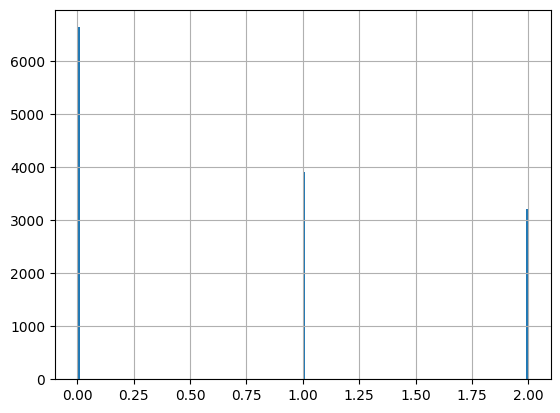

In [32]:
#Definindo a variável alvo
df['target'] = np.ceil(df['delivery_delay'] / 7.).clip(-2, 0).astype(int)
df['target'] = df['target'] - df['target'].min()
df['target'].hist(bins=200)
print('Proporção das classes:\n{0}'.format((df['target'].value_counts() / df['target'].shape[0])))
plt.show()

A maioria das ordens chegam com atraso no local. 

# "Target Enconder" com Clusters

Existem diferenças na velocidade da entrega em cada região do país, o mesmo acontece para os estados. Por exemplo, no Rio de Janeiro, existem regiões onde os produtos tem um atraso maior, geralmente elas se encontram na periferia. A ideia é usar o algoritmo de Density-Based Spatial Clustering of Applications with Noise (DBSCAN) para separar essa regiões em grupos. Porém, nos vamos utilizar a informação sobre a variável ``is_delayed`` para avaliar se os cluster estão separados de forma relevante para o nosso algoritmo.

In [33]:
from sklearn.cluster import DBSCAN

In [34]:
cluster_cols = [
                'purchase_month',
                'order_item_qty',
                'product_volume',
                'purchase_day',

                'customer_zip2',
                'customer_zip3',
                
                'review_score',

                'same_state'
               ]

In [35]:
dbscan = DBSCAN(n_jobs=-1, eps=0.008, min_samples=20,
                metric='cosine',
                )
dbscan.fit(MinMaxScaler().fit_transform(df[cluster_cols]))

DBSCAN(eps=0.008, metric='cosine', min_samples=20, n_jobs=-1)

In [36]:
df['db_label'] = dbscan.labels_

In [37]:
db_group = df[['db_label', 'is_delayed']]\
                                        .groupby('db_label')\
                                        .agg({'is_delayed':['mean', 'count']})\
                                        .sort_values(('is_delayed', 'count'),
                                                     ascending=False)

Como a label  ``is_delayed`` possui valor 0 ou 1, se a média de um grupo estiver muito próxima de 0 isso significa que este grupo possui muitos pedidos atrasados. No caso contrário, onde temos uma média próxima de 1, os grupos identificam onde os pedidos não atrasam.

In [38]:
db_group

is_delayed      
               mean count
db_label                 
 1         0.041256  5890
-1         0.261778  4118
 0         0.046789  3270
 2         0.541096   146
 9         0.720339   118
 5         0.596491    57
 4         0.326087    46
 8         0.613636    44
 3         0.621622    37
 10        0.708333    24
 7         0.750000    20
 6         0.076923    13

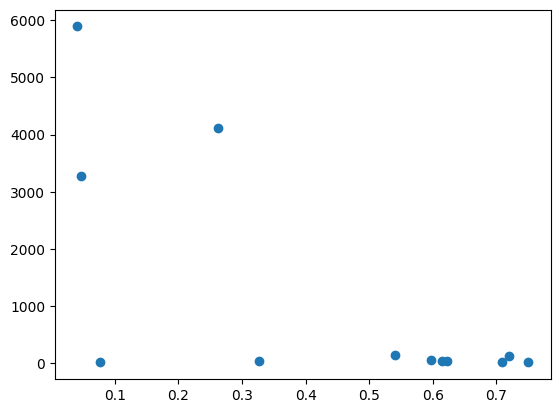

In [39]:
plt.scatter(x=db_group[('is_delayed', 'mean')], y=db_group[('is_delayed', 'count')])
plt.show()

#Fazendo previsões

In [40]:
#Colunas consideradas no modelo
columns = [
           'freight_value',
           'customer_seller_dist',
           'product_density',
           'purchase_month',
           'order_item_qty',
           'product_volume',
           'purchase_day',

           'customer_zip1',
           'customer_zip2',
           'customer_zip3',
           'customer_zip4',
           
           'same_state',

           'review_score', 'db_label',
           
          ]

In [41]:
#Checando se existem NaNs
df[columns].isna().sum()

freight_value           0
customer_seller_dist    0
product_density         0
purchase_month          0
order_item_qty          0
product_volume          0
purchase_day            0
customer_zip1           0
customer_zip2           0
customer_zip3           0
customer_zip4           0
same_state              0
review_score            0
db_label                0
dtype: int64

## Random Forest

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [43]:
X = df[columns]
y_hat = df['target']

In [44]:
grid_pipe = Pipeline([
                      ('decision_tree', DecisionTreeClassifier()),
                    ])

In [45]:
param_grid = [
              {'decision_tree__max_depth': [3, 10, 15, 20, 30], 
               'decision_tree__max_features': ['log2', 'sqrt', df[columns].shape[1]],
               'decision_tree__min_samples_split': [50, 100,  500, 1000],
               'decision_tree__splitter': ['best', 'random']},
             ]

grid_search = GridSearchCV(grid_pipe, param_grid, cv=5,
                            scoring='accuracy',
                            n_jobs=-1)

_ = grid_search.fit(X, y_hat)

In [46]:
grid_search.best_params_

{'decision_tree__max_depth': 3,
 'decision_tree__max_features': 14,
 'decision_tree__min_samples_split': 50,
 'decision_tree__splitter': 'best'}

In [47]:
tree_clf = grid_search.best_estimator_

In [48]:
feature_importances = tree_clf[0].feature_importances_

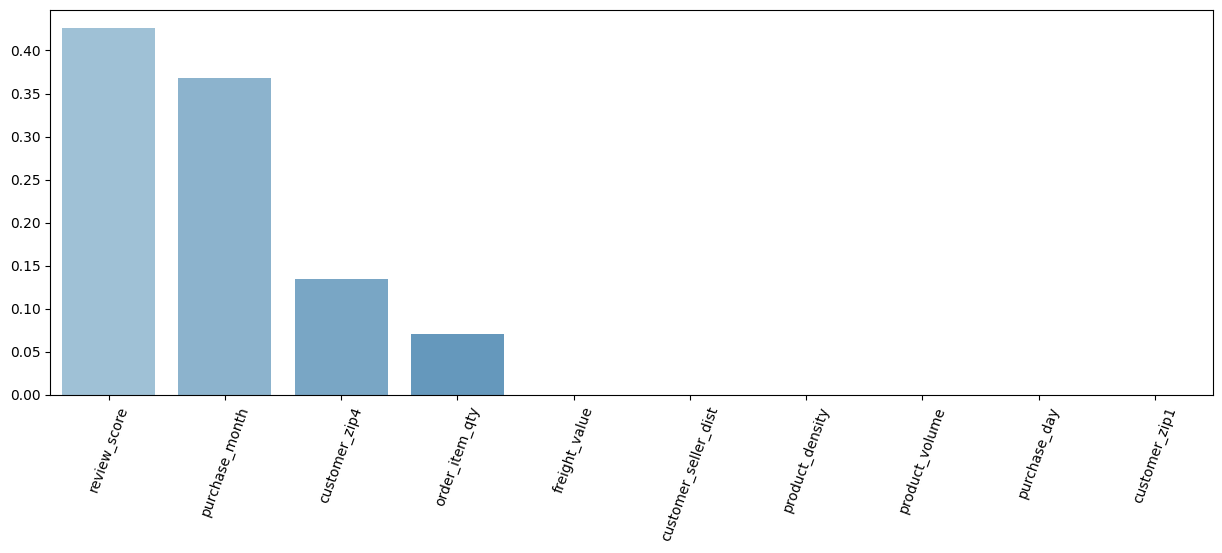

In [49]:
#@title "Importância das Features"
plt.figure(figsize=[15, 5])
top_10 = pd.DataFrame(feature_importances, index=df[columns].columns).sort_values(0, ascending=False).head(10)
top_features = list(top_10.index)

sns.barplot(data=top_10.T, palette="Blues_d")
plt.xticks(rotation=70)
plt.show()

In [50]:
#@title Acurácia do modelo
_ = return_scores(tree_clf, X, y_hat, name='Decision Tree', scoring=["accuracy"])

<accuracy>: 0.559 accuracy_err: 0.031


In [51]:
pred = tree_clf.predict(X)

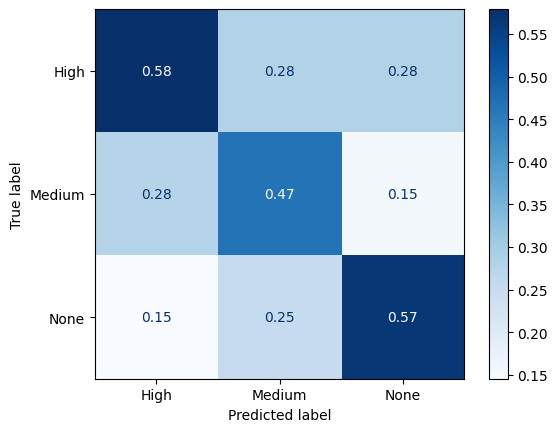

In [52]:
#@title Matrix Confusão (Recall)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf = confusion_matrix(df['target'], pred, normalize='pred')
disp = ConfusionMatrixDisplay(conf, display_labels=['High', 'Medium', 'None'])
disp.plot(cmap='Blues')
plt.show()

57% das vezes que o modelo afirma que não haverá atrasos na entre ele está correto.

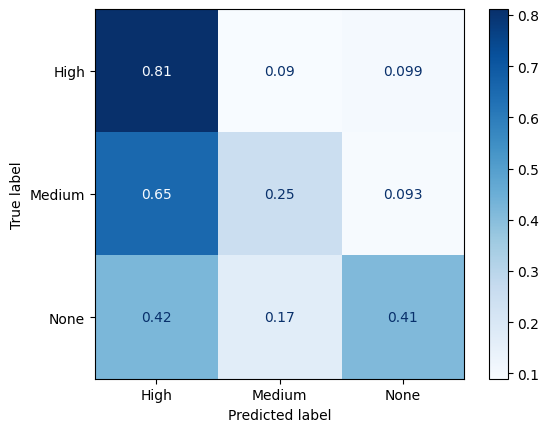

In [53]:
#@title Matrix Confusão (Precision)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf = confusion_matrix(df['target'], pred, normalize='true')
disp = ConfusionMatrixDisplay(conf, display_labels=['High', 'Medium', 'None'])
disp.plot(cmap='Blues')
plt.show()

O modelo identifica a maioria das entregas que serão feitas com um atraso grande. Além disso, como é esperado nessas situações, ainda mais com um modelo simples, existe uma imprecisão no modelo ao separar atrasos grandes (High) de atrasos pequenos (Medium), e ao separar atrasos pequenos (Medium) com nenhum atraso (None). 

# Resultados

No dataset, as estimativas para a entrega estão corretas somente 20% das vezes. O nosso modelo, apesar de simples, consegue avisar sobre o atraso do produto com 55%~57% de acurácia. O modelo também se mostrou muito preciso para identificar atrasos grandes. Com este modelo podemos avisar previamente o comprador de possíveis atrasos na entrega. Esperamos que este aviso diminua a insatisfação com o cliente com o atraso.

> Sem o uso do DBSCAN para identificar os clusters, a acurácia do modelo cai para ~52%.

#DNN com layers de preprocessamento

Esse modelo obtém resultados um pouco melhores.

### Imports

In [54]:
import numpy as np

In [55]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Input
from keras import layers
from keras.callbacks import ModelCheckpoint 

from tensorflow.keras.utils import plot_model

from keras.layers import Dense

In [56]:
tf.keras.backend.clear_session()

### Auxiliary Functions


In [57]:
from IPython.display import display

def visualize(summary, visualize_graph, model, model_name):

  if summary == True:
    model.summary()

  if visualize_graph == True:
    try:
      display(keras.utils.plot_model(model, show_shapes=True, rankdir="LR"))
    except:
      print('Run: \n!pip install pydot \
                  \n!pip install pydotplus \
                  \n!pip install graphviz \
                  \n!apt-get install graphviz -y')
        
  return

In [58]:
def get_normalization_layer(name, dataset):

  normalizer = layers.Normalization()

  feature_ds = dataset[name]

  normalizer.adapt(feature_ds)

  return normalizer

def get_discretization_layer(name, dataset, num_bins):

  discretizer = layers.Discretization(num_bins=num_bins, epsilon=1e-10)
      
  feature_ds = dataset[name]

  discretizer.adapt(feature_ds)

  return discretizer

def get_category_encoding_layer(name, dataset, dtype, output_mode='int', max_tokens=None):
  
  if dtype == 'string':
    #Note that, for strings, index 0 is reserved for out-of-vocabulary values
    #(values that were not seen during adapt()).
    categories = layers.StringLookup(max_tokens=max_tokens, output_mode=output_mode)
  else:
    #Note that, for integers, index 0 is reserved for missing values 
    #(which you should specify as the value 0), and index 1 is reserved for
    # out-of-vocabulary values (values that were not seen during adapt())
    categories = layers.IntegerLookup(max_tokens=max_tokens, output_mode=output_mode)
    
  feature_ds = dataset[name]

  categories.adapt(feature_ds)

  return categories

### Model Definitions

In [59]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = 'adam'
metrics = ['accuracy']
model_name = 'base_model'
val_metrics = 'val_loss'

In [60]:
folder_path = './logs1'

In [61]:
batch_size = df.shape[0]
epochs = 2500
workers = 7

### Initialize Tensorboard

In [62]:
%load_ext tensorboard

In [63]:
%tensorboard --logdir $folder_path --host 0.0.0.0

### Create Preprossing Layers 

In [64]:
oh = [
      'purchase_month',
      'db_label',
      'review_score',
      ]

continuous = [
              'product_volume',
              'order_item_qty',
              ]

categorical = [
               'same_state',
               ]

In [65]:
cols_order = oh + continuous + categorical

In [66]:
norm_cols = continuous
disc_cols = []
onehot_cols = oh
cat_cols = categorical
print('Normalization: {}\nDiscretization: {}\nOneHot: {}\nCategorical: {}'.format(norm_cols, disc_cols, onehot_cols, cat_cols))

Normalization: ['product_volume', 'order_item_qty']
Discretization: []
OneHot: ['purchase_month', 'db_label', 'review_score']
Categorical: ['same_state']


In [67]:
#Stack the preprocessing layers and the input layers.
input_layers = [] # Enters in model.fit
preprocess_layers = [] # Enter in Sequential()

#Normalization loop
for name in norm_cols:
  
  layer = get_normalization_layer(name, df)

  input_layer = tf.keras.Input(shape=(1,), name=name)
  preprocess_layer = layer(input_layer)

  input_layers.append(input_layer)
  preprocess_layers.append(preprocess_layer)

#Discretization loop
for name in disc_cols:
  
  layer = get_discretization_layer(name, df, num_bins=4)

  input_layer = tf.keras.Input(shape=(1,), name=name)
  preprocess_layer = tf.cast(layer(input_layer), dtype=tf.float32)

  input_layers.append(input_layer)
  preprocess_layers.append(preprocess_layer)

#One-Hot Enconding loop
for name in onehot_cols:
  
  layer = get_category_encoding_layer(name, df, dtype='float32',
                                      output_mode='one_hot')

  input_layer = tf.keras.Input(shape=(1,), name=name)
  preprocess_layer = layer(input_layer)

  input_layers.append(input_layer)
  preprocess_layers.append(preprocess_layer)

#Categorical loop
for name in cat_cols:
  
  layer = get_category_encoding_layer(name, df, 'int', max_tokens=None)

  input_layer = tf.keras.Input(shape=(1,), name=name, dtype=tf.int64)
  preprocess_layer = tf.cast(layer(input_layer), dtype=tf.float32)

  input_layers.append(input_layer)
  preprocess_layers.append(preprocess_layer)

del layer
del input_layer

In [68]:
#input_layers, preprocess_layers

### Create Model

In [69]:
def Funcitonal_API(input):

  '''
     The functional API can handle models with non-linear topology,
     shared layers, and even multiple inputs or outputs.
  '''

  x = tf.keras.layers.Dense(20)(input)
  x = tf.keras.activations.relu(x, alpha=0.25)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.Dense(15, activation='relu')(x)
  x = tf.keras.layers.Dense(3)(x)

  output = x

  model = Model(input_layers, output, name=model_name)

  return model

In [70]:
def Create_Model(X):

  x_input = tf.keras.layers.concatenate(preprocess_layers)

  model = Funcitonal_API(x_input)

  return model

### Build and Compile

In [71]:
def Model_Build_Compile(X, loss_fn, metrics='accuracy',
                        optimizer='adam', summary=False,
                        visualize_graph=False):

    model = Create_Model(X)

    model.compile(
                  loss=loss_fn,
                  optimizer=optimizer,
                  metrics=metrics,
                  )

    if summary or visualize_graph == True:
      visualize(summary, visualize_graph, model, model_name)

    return model

In [72]:
model = Model_Build_Compile(X, loss_fn, metrics, optimizer,
                            summary=False, visualize_graph=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


None

### Callbacks - Basic

In [73]:
import os
import datetime
from datetime import datetime
import pytz

tz_SP = pytz.timezone('America/Sao_Paulo')

In [74]:
logdir = os.path.join(folder_path, model_name \
                     # + '-' + datetime.now(tz_SP).strftime("%Y-%m-%d_%H:%M:%S")
                      )
print('Path to the logs: {0}'.format(logdir))

Path to the logs: ./logs1/base_model


In [75]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,
                                                      write_graph=False,
                                                      write_images=1,
                                                      histogram_freq=1,
                                                      )

In [76]:
def scheduler(epoch, lr):
  if epoch < 1500:
    return lr
  else:
    return 0.005

In [77]:
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

### Model Fit - Basic

In [82]:
X = [df[name].values for name in cols_order]
y_hat = pd.get_dummies(df['target']).values

In [ ]:
#TensorBoard não está funcionando com as layers de preprocessamento. (!?)
hist = model.fit(X, y_hat,
                 #validation_data=(,),
                 validation_split=0.1,
                 initial_epoch=0,
                 verbose=1,
                 callbacks=[scheduler_callback],
                 workers=workers,
                 batch_size=batch_size,
                 epochs=epochs,)

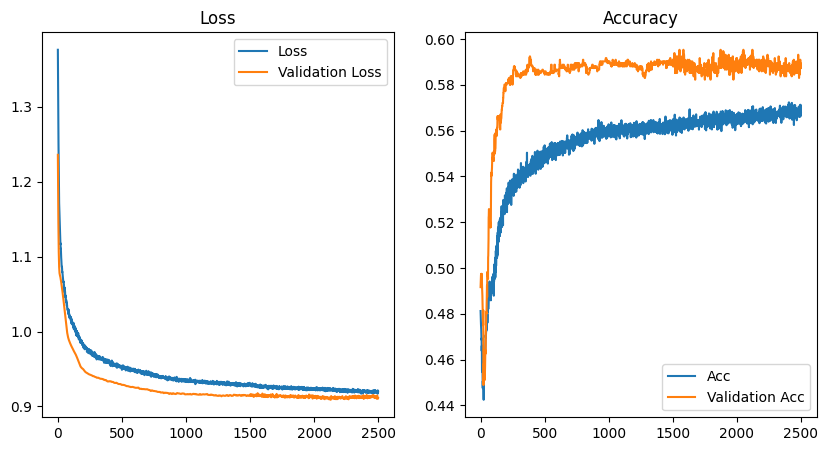

In [80]:
plt.figure(figsize=[10, 5])

plt.subplot(121)
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist.history['accuracy'], label='Acc')
plt.plot(hist.history['val_accuracy'], label='Validation Acc')
plt.title('Accuracy')
plt.legend()

plt.show()

> Na imagem acima, vemos que o dataset de validação tem uma acurácia melhor do que o dataset de treino. Isso acontece porque o Keras separou, aleatoriamente, um dataset de validação com amostras mais fáceis de serem classificadas do que as presentes no dataset de treino.

O algoritmo de DNN possui acurácia, precisão e recall melhores do que as vistas para o RandomTree.

In [81]:
model.evaluate(X, y_hat)

431/431 [==============================] - 1s 2ms/step - loss: 0.9114 - accuracy: 0.5739


[0.9114481806755066, 0.5738953948020935]

In [137]:
#Adicionando a layer de probabilidade ao modelo

last_layer_output = model.layers[-1].output
x = tf.keras.layers.Softmax()(last_layer_output)
output_prob = tf.math.argmax(x, axis=1)
prob_model = Model(model.input, output_prob)

In [138]:
pred = prob_model.predict(X)

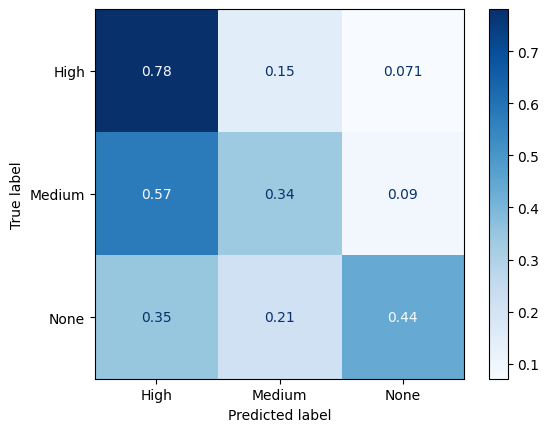

In [139]:
#@title Matriz Confusão (Precision)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf = confusion_matrix(df['target'], pred, normalize='true')
disp = ConfusionMatrixDisplay(conf, display_labels=['High', 'Medium', 'None'])
disp.plot(cmap='Blues')
plt.show()

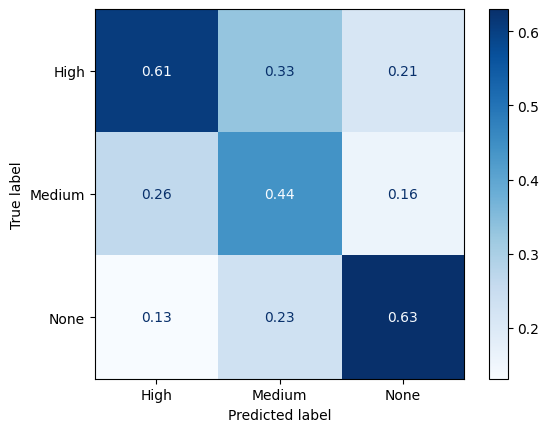

In [140]:
#@title Matriz Confusão (Recall)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf = confusion_matrix(df['target'], pred, normalize='pred')
disp = ConfusionMatrixDisplay(conf, display_labels=['High', 'Medium', 'None'])
disp.plot(cmap='Blues')
plt.show()